In [177]:
# imports

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [178]:
# config

config = {
    'seed': 12345
}

In [179]:
# load data

df = pd.read_csv('data/reviews_preprocessed.csv')

df['rating_item'] = df['rating_item'].fillna(0)
df['rating_delivery'] = df['rating_delivery'].fillna(0)
df['rating_seller'] = df['rating_seller'].fillna(0)
df['rating_marketplace'] = df['rating_marketplace'].fillna(0)

df['rating_item'] = df['rating_item'].astype(int)
df['rating_delivery'] = df['rating_delivery'].astype(int)
df['rating_seller'] = df['rating_seller'].astype(int)
df['rating_marketplace'] = df['rating_marketplace'].astype(int)

In [180]:
# transform data

df['title'] = df['title'].fillna('')
df['review'] = ((df['title'] + ' ') if len(df['title']) > 0 else '') + df['body']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df[['rating_item', 'rating_delivery', 'rating_seller', 'rating_marketplace']]

In [181]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [143]:
# train model

tuning_grid = {
    'estimator__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'estimator__C': range(1, 11, 1),
    'estimator__degree': range(11),
    'estimator__gamma': ['scale', 'auto'],
}

tuning_cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = config['seed'])
gridSearch = RandomizedSearchCV(estimator = MultiOutputClassifier(SVC()), param_distributions = tuning_grid, n_iter = 50, n_jobs = -1, random_state = config['seed'], 
    cv = tuning_cv, scoring = "accuracy", verbose = 1)
searchResults = gridSearch.fit(X_train, y_train)
model = searchResults.best_estimator_
print('The best model: ' + str(model))

MultiOutputClassifier(estimator=SVC())

In [144]:
# test model

y_predicted = model.predict(X_test)

Accuracy:  {'rating_item': 0.34, 'rating_delivery': 0.4083333333333333, 'rating_seller': 0.425, 'rating_marketplace': 0.43}
Average accuracy:  0.4008333333333333


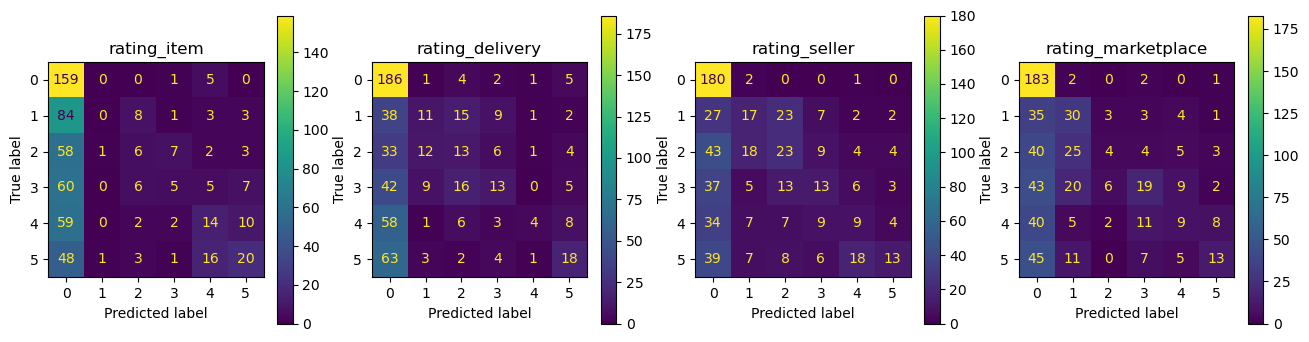

In [145]:
# show results

accuracy = {}

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

cm = confusion_matrix(y_test['rating_item'], y_predicted[:, 0], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[0])
axs[0].set_title('rating_item')
accuracy['rating_item'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_test['rating_delivery'], y_predicted[:, 1], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[1])
axs[1].set_title('rating_delivery')
accuracy['rating_delivery'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_test['rating_seller'], y_predicted[:, 2], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[2])
axs[2].set_title('rating_seller')
accuracy['rating_seller'] = cm.diagonal().sum() / cm.sum()

cm = confusion_matrix(y_test['rating_marketplace'], y_predicted[:, 3], labels=model.classes_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_[0])
disp.plot(ax=axs[3])
axs[3].set_title('rating_marketplace')
accuracy['rating_marketplace'] = cm.diagonal().sum() / cm.sum()

print('Accuracy: ', accuracy)
print('Average accuracy: ', sum(accuracy.values()) / len(accuracy))

plt.show()

In [ ]:
with open('model/svm.pkl', 'rb') as f:
    clf = pickle.load(f)